# Working with audio data

In [ ]:
import torch
import torchaudio
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# http://www.openslr.org/1/
# Sixty recordings of one individual saying yes or no in Hebrew; each recording is eight words long.
yesno_data = torchaudio.datasets.YESNO('.', download=True)

data_loader = torch.utils.data.DataLoader(
    yesno_data,
    batch_size=1)

  0%|          | 0.00/4.49M [00:00<?, ?B/s]

In [ ]:
yesno_data[0]  # Returns the waveform, sample rate, and labels.

(tensor([[ 3.0518e-05,  6.1035e-05,  3.0518e-05,  ..., -1.8616e-03,
          -2.2583e-03, -1.3733e-03]]), 8000, [0, 0, 0, 0, 1, 1, 1, 1])

In [ ]:
# It's always good to plot shapes.
yesno_data[0][0].shape  # Waveform tensor shape.

torch.Size([1, 50800])

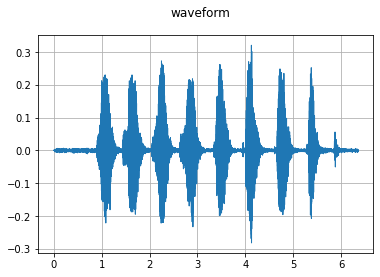

In [ ]:
def plot_waveform(waveform, sample_rate):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle("waveform")
    plt.show(block=False)

plot_waveform(yesno_data[0][0], yesno_data[0][1])  # You could treat the audio data as a timeseries. 

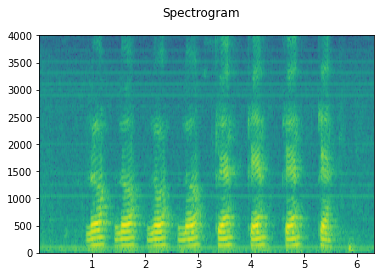

In [ ]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

plot_specgram(yesno_data[0][0], yesno_data[0][1])  # You could treat the audio data as an image.

In [ ]:
# Also: https://arxiv.org/pdf/1904.03670.pdf

## Working with text data 

In [ ]:
from sklearn.datasets import fetch_20newsgroups
twenty_train = fetch_20newsgroups(subset='train', 
                                  categories=['alt.atheism', 'soc.religion.christian', 
                                              'comp.graphics'],  
                                  shuffle=True, random_state=42)
twenty_test = fetch_20newsgroups(subset='test', 
                                 categories=['alt.atheism', 'soc.religion.christian', 
                                             'comp.graphics'], 
                                 shuffle=True, random_state=42)

# This is out of distribution data. Not seen in training. 
twenty_ood = fetch_20newsgroups(subset='test', 
                                 categories=['sci.med','sci.space','rec.autos'], 
                                 shuffle=True, random_state=42)

In [ ]:
dir(twenty_train)

['DESCR', 'data', 'filenames', 'target', 'target_names']

In [ ]:
print(twenty_train.data[0])

From: chrisb@tafe.sa.edu.au (Chris BELL)
Subject: Re: Don't more innocents die without the death penalty?
Organization: South Australian Regional Academic and Research Network
Lines: 19
Distribution: world
NNTP-Posting-Host: baarnie.tafe.sa.edu.au

"James F. Tims" <p00168@psilink.com> writes:

>By maintaining classes D and E, even in prison, it seems as if we 
>place more innocent people at a higher risk of an unjust death than 
>we would if the state executed classes D and E with an occasional error.

I would rather be at a higher risk of being killed than actually killed by
                              ^^^^                      ^^^^^^^^
mistake.  Though I do agree with the concept that the type D and E murderers
are a massive waste of space and resources I don't agree with the concept:

	killing is wrong
	if you kill we will punish you
	our punishment will be to kill you.

Seems to be lacking in consistency.

--
"I know" is nothing more than "I believe" with pretentions.



In [ ]:
twenty_train.target_names[twenty_train.target[0]]

'alt.atheism'

In [ ]:
# Now we turn the text data into a set of numerical vectors.
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer(stop_words='english')
X_train_counts = count_vect.fit_transform(twenty_train.data)
X_train_counts.shape

(1663, 27525)

In [ ]:
print(np.max(X_train_counts[0].todense()))
print(np.max(X_train_counts[4].todense()))

2
6


In [ ]:
# Use TFIDF to standardize the counts between documents.
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(1663, 27525)

In [ ]:
print(np.max(X_train_tfidf[0].todense()))
print(np.max(X_train_tfidf[4].todense()))

0.2754459359021429
0.5913847220492682


In [ ]:
# Apply the transforms to the test and OOD data.
X_test_counts = count_vect.transform(twenty_test.data)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

X_ood_counts = count_vect.transform(twenty_ood.data)
X_ood_tfidf = tfidf_transformer.transform(X_ood_counts)

## Classification

In [ ]:
from sklearn.neural_network import MLPClassifier

# Train 5 models. See the Deep Ensembles paper:
# https://proceedings.neurips.cc/paper/2017/file/9ef2ed4b7fd2c810847ffa5fa85bce38-Paper.pdf
models = [MLPClassifier(hidden_layer_sizes=(50,50)), 
          MLPClassifier(hidden_layer_sizes=(50,50)),
          MLPClassifier(hidden_layer_sizes=(50,50)),
          MLPClassifier(hidden_layer_sizes=(50,50)),
          MLPClassifier(hidden_layer_sizes=(50,50))]

for model in models:
    model.fit(X_train_tfidf, twenty_train.target)

In [ ]:
# Predict on test and out of distribution data.
preds_test = []
preds_ood = []
for model in models:
    preds_test.append(model.predict_proba(X_test_tfidf))
    preds_ood.append(model.predict_proba(X_ood_tfidf))

preds_test = np.array(preds_test)
preds_ood = np.array(preds_ood)

In [ ]:
preds_test.shape  # The shape is (number of models, number of data points, number of classes).

(5, 1106, 3)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(twenty_test.target, np.argmax(np.mean(preds_test,axis=0),axis=1)))

              precision    recall  f1-score   support

           0       0.98      0.87      0.92       319
           1       0.96      0.98      0.97       389
           2       0.91      0.97      0.94       398

    accuracy                           0.95      1106
   macro avg       0.95      0.94      0.95      1106
weighted avg       0.95      0.95      0.95      1106



In [ ]:
# https://arxiv.org/pdf/1803.08533.pdf
# We can measure uncertainty. The model uncertainty is estimated by the following from the above paper.
# We can compare uncertainty for in and out of distribution data.
indist_uncertainty = np.mean(np.var(preds_test,axis=0),axis=1)
ood_uncertainty = np.mean(np.var(preds_ood,axis=0),axis=1)

Text(0.5, 1.0, 'Uncertainty')

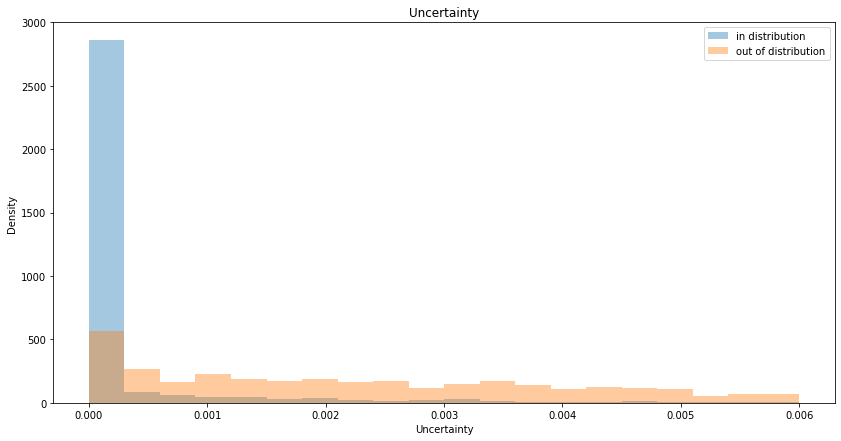

In [ ]:
# Out of distribution data tend to have higher uncertainty.
plt.figure(figsize=(14,7))
plt.hist(indist_uncertainty, label='in distribution', alpha=0.4, density=True, bins=20, range=(0,0.006))
plt.hist(ood_uncertainty, label='out of distribution', alpha=0.4, density=True, bins=20, range=(0,0.006))
plt.legend()
plt.xlabel('Uncertainty')
plt.ylabel('Density')
plt.title('Uncertainty')

In [ ]:
is_correct = twenty_test.target==np.argmax(np.mean(preds_test,axis=0),axis=1)

# We can compare uncertainty for test data points the model got wrong and correct.
correct_uncertainty = np.mean(np.var(preds_test[:,is_correct,:],axis=0),axis=1)
mistake_uncertainty = np.mean(np.var(preds_test[:,~is_correct,:],axis=0),axis=1)

Text(0.5, 1.0, 'Uncertainty')

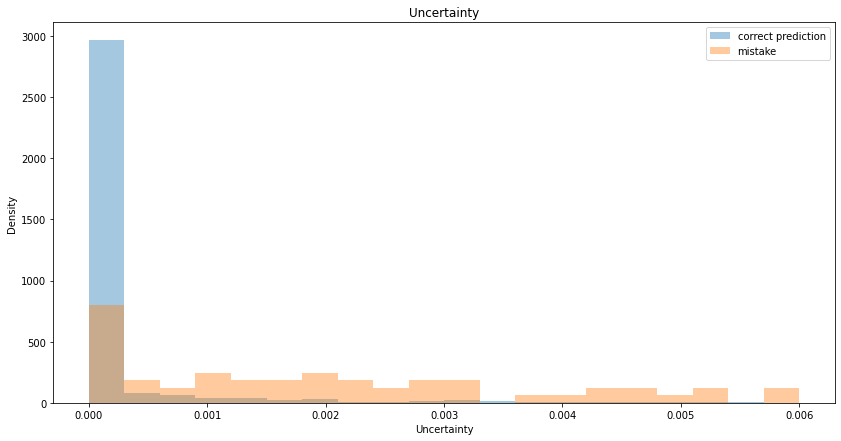

In [ ]:
# Wrong predictions tend to have higher uncertainty.
plt.figure(figsize=(14,7))
plt.hist(correct_uncertainty, label='correct prediction', alpha=0.4, density=True, bins=20, range=(0,0.006))
plt.hist(mistake_uncertainty, label='mistake', alpha=0.4, density=True, bins=20, range=(0,0.006))
plt.legend()
plt.xlabel('Uncertainty')
plt.ylabel('Density')
plt.title('Uncertainty')

## Latent Dirichlet Allocation

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(
    n_components=3,
    random_state=42
)
lda.fit(X_train_counts)


LatentDirichletAllocation(n_components=3, random_state=42)

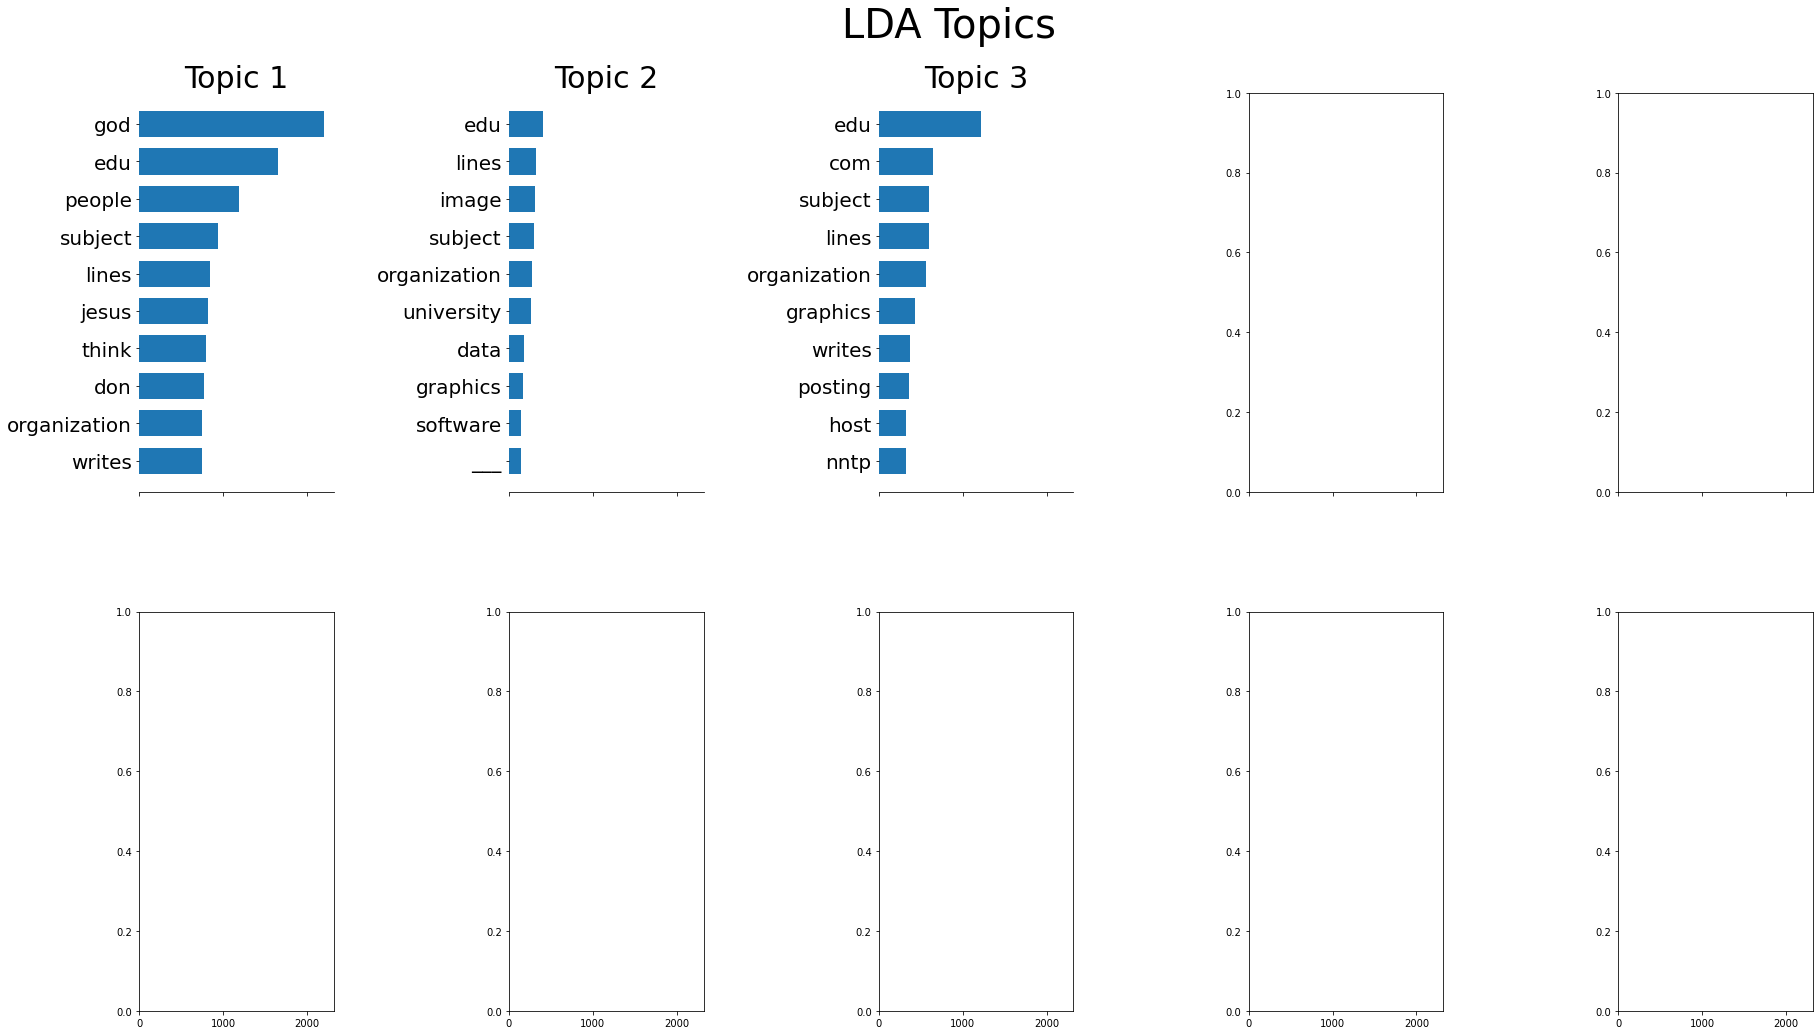

In [ ]:
def plot_top_words(model, feature_names, n_top_words, title):
    fig, axes = plt.subplots(2, 5, figsize=(30, 15), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx +1}", fontdict={"fontsize": 30})
        ax.invert_yaxis()
        ax.tick_params(axis="both", which="major", labelsize=20)
        for i in "top right left".split():
            ax.spines[i].set_visible(False)
        fig.suptitle(title, fontsize=40)

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=0.90, hspace=0.3)
    plt.show()

plot_top_words(lda, count_vect.get_feature_names_out(), 10, 'LDA Topics')

In [ ]:
# Embed the documents as distributions over topics.
X_train_topics = lda.transform(X_train_counts)
X_train_topics.shape

(1663, 3)

In [ ]:
# We can use PCA to project the topic space down to two dimensions.
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_train_topics_pca = pca.fit_transform(X_train_topics)

In [ ]:
points_of_interest = pca.transform([[1.0,0.0,0.0],[0.0,1.0,0.0], [0.0,0.0,1.0]])

In [ ]:
points_of_interest[0,0]

-0.5953197123551124

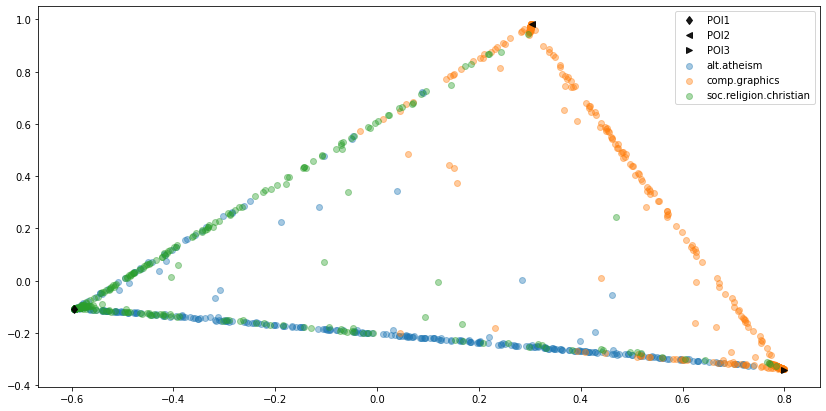

In [ ]:
plt.figure(figsize=(14,7))
plt.scatter(X_train_topics_pca[twenty_train.target==0,0],X_train_topics_pca[twenty_train.target==0,1], alpha=0.4, label=twenty_train.target_names[0])
plt.scatter(X_train_topics_pca[twenty_train.target==1,0],X_train_topics_pca[twenty_train.target==1,1], alpha=0.4, label=twenty_train.target_names[1])
plt.scatter(X_train_topics_pca[twenty_train.target==2,0],X_train_topics_pca[twenty_train.target==2,1], alpha=0.4, label=twenty_train.target_names[2])

plt.plot([points_of_interest[0,0]],[points_of_interest[0,1]], 'kd', alpha=0.9, label='POI1')
plt.plot([points_of_interest[1,0]],[points_of_interest[1,1]], 'k<', alpha=0.9, label='POI2')
plt.plot([points_of_interest[2,0]],[points_of_interest[2,1]], 'k>', alpha=0.9, label='POI3')

plt.legend()

## Why it is important to standardize features.

(-20.0, 20.0)

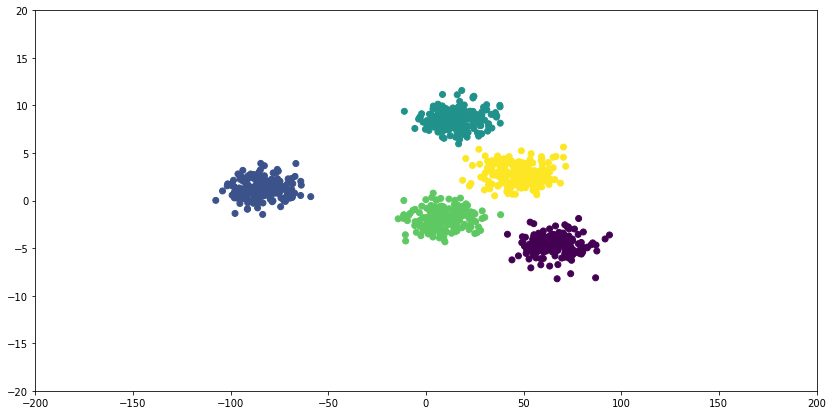

In [ ]:
from sklearn.datasets import make_blobs
X, centers = make_blobs(n_samples=1000, n_features=2, centers=5)

X[:,0] = X[:,0] * 10

plt.figure(figsize=(14,7))
plt.scatter(X[:,0], X[:,1], c=centers)
#plt.xlim([-20,20])
plt.xlim([-200,200])
plt.ylim([-20,20])

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5)
pred_labels = kmeans.fit_predict(X)

(-200.0, 200.0)

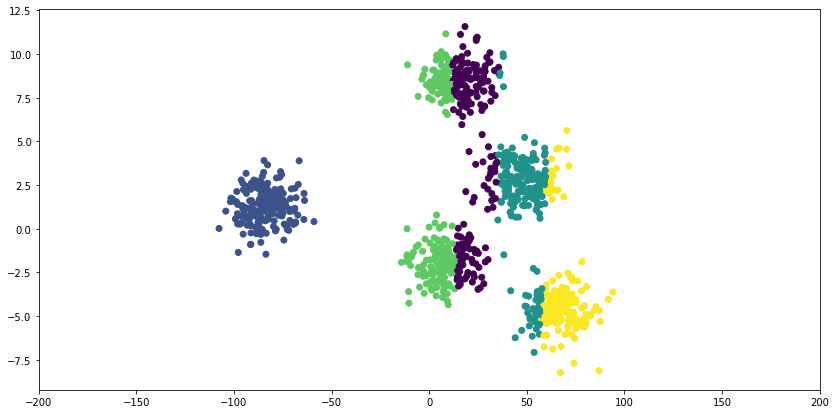

In [ ]:
plt.figure(figsize=(14,7))
plt.scatter(X[:,0], X[:,1], c=pred_labels)
plt.xlim([-20,20])
plt.xlim([-200,200])
#plt.ylim([-20,20])

In [ ]:
# It is important to standardize your data.